In [2]:
from gym import Env
from gym.spaces import Discrete, Box, Tuple
import numpy as np
import random
import matplotlib.pyplot as plt
from pyfmi import load_fmu
from Dymola_Env import DymolaEnv, scale_and_clamp_values

In [21]:
class DymolaEnv(Env):
    def __init__(self):
        # define action space
        self.action_space = Tuple((
            Box(low=np.array([0.25]), high=np.array([0.8]),dtype=np.float32),  # Agent 0: Flow_r, Regeneration air flowrate
            Box(low=np.array([1]), high=np.array([100]),dtype=np.float32),  # Agent 1: N, Rotation speed of Desiccant wheel
            Box(low=np.array([273.15]), high=np.array([353.15]),dtype=np.float32),  # Agent 2: Tset2, Temperature setpoint of Heater 2
        ))
        # define observation space
        self.observation_space=Box(low=np.array([0]), high=np.array([1]),dtype=np.float32)
        
        # load fmu file
        self.model=load_fmu("DWHP1_fmu 1.fmu", kind='cs', log_level=2)
        
        self.output=30 ## numbers of outputs
        self.start_time = 0  #
        self.end_time = 10*3600 #
        self.current_time= self.start_time 
        self.step_size = 300  # Define your own step size, unit is second, 300s = 5min
        self.done = False
        self.energy=0
        self.num_agents=len(self.action_space)
        self.power_ref= 6000.0
        self.Temp_d= 273.15+46
        self.RH_d = 0.1

        # Create a list with 30 elements, all of which are 0, using iteration
        zero_list = []
        for _ in range(self.output):
            zero_list.append(0)

        self.state=zero_list
        # Initialize the model with the start time
        self.model.reset()
        self.model.initialize(self.start_time)
        print("success boot")
        
        # set start temp
        # self.state=np.array([38+random.uniform(-3, 3), 38+random.uniform(-3, 3), 38+random.uniform(-3, 3)])
        # Temparture, Mo
        #self.state=np.array([25.0, 1.0])
        # set shower length
        self.time_id=0
        self.dt=0.2
        self.error_thres=0.001

    def step(self, action):
        #set action parameters
        paras = action
        self.model.set('FLOW_p', paras[0])
        self.model.set('FLOW_r', paras[1])
        self.model.set('N', paras[2])
        self.model.set('SP_HP', paras[3])
        self.model.set('Tset1', paras[4])
        self.model.set('Tset2', paras[5])

        self.model.do_step(self.current_time, self.step_size, True)

        #Caluculate Observation
        observation_all=[]

        for i in range(self.output):
            self.state[i]=self.model.get(f"y{i}")[0]
            if i>=6 and i%3 !=2:
                observation_all.append(self.state[i])
        
        agents_dict={}

        for i in range(self.num_agents):
            key = f'agent_{i}'
            value = observation_all.copy()
            agents_dict[key] = value

        agents_dict['agent_0'].append(self.state[1])
        agents_dict['agent_1'].append(self.state[2])
        agents_dict['agent_2'].append(self.state[5])

        self.obs_env=agents_dict


        
            
        
        self.current_time += self.step_size

        # Check if shower is done
        if self.current_time >=self.end_time:
            self.done = True
            self.model.terminate() 
            print("dymola model end")
        else:
            self.done = False

        # Apply temperature noise
        #self.state += random.randint(-1,1)
        # Set placeholder for info
        Temp_d= self.Temp_d
        RH_d = self.RH_d
        
        
        Temp_fc=self.state[27]
        RH_fc=self.state[28]
        
        
        humidity_error=abs(RH_d-RH_fc)
        temp_error=abs(Temp_d-Temp_fc)

        #calculate power
        power=0
        for i in range(6):
            power+=self.state[i]
        
        self.energy+=power*self.step_size
        
        
        #calculate reward
        if humidity_error<0.005:
            hum_reward=1
        else:
            hum_reward=-1

        if temp_error<1:
            temp_reward=1
        else:
            temp_reward=-1

        power_reward=(self.power_ref-power)/self.power_ref

        reward_all=hum_reward+temp_reward+power_reward

        reward={}

        for i in range(self.num_agents):
            key = f'agent_{i}'
            value = reward_all.copy()
            reward[key] = value

        
        done={}

        for i in range(self.num_agents):
            key = f'agent_{i}'
            value = self.done
            done[key] = value


        info = {}

        #return step information
        return self.obs_env, reward, done, info

    def render(self):
        print(self.state)
        pass

    def reset(self):
        # Initialize the model with the start time
        if self.current_time>=self.end_time:
            self.model=load_fmu("DWHP1_fmu 1.fmu", kind='cs', log_level=2)
            self.model.reset()
            self.model.initialize(self.start_time)
            self.current_time=0
            self.energy=0
            print("time reset")

        #Caluculate Observation
        observation_all=[]

        for i in range(self.output):
            self.state[i]=self.model.get(f"y{i}")[0]
            if i>=6 and i%3 !=2:
                observation_all.append(self.state[i])
        
        agents_dict={}

        for i in range(self.num_agents):
            key = f'agent_{i}'
            value = observation_all.copy()
            agents_dict[key] = value

        agents_dict['agent_0'].append(self.state[1])
        agents_dict['agent_1'].append(self.state[2])
        agents_dict['agent_2'].append(self.state[5])

        self.obs_env=agents_dict

        info = []

        
        print("reset activate")
        return self.obs_env, info
        


In [5]:
env=DymolaEnv()
episodes=3


for episode in range(1, episodes+1):
    time=[]
    Temp_fc=[]
    RH_fc=[]
    Energy=[]
    Flow_r=[]
    N=[]
    Tset2=[]
    score_all=[]

    
    n_state,info=env.reset()
    done = False
    score = 0
    count=0

    while not done:
        action=[0.4,env.action_space[0].sample().item(),env.action_space[1].sample().item(),0.5,273.15+46,env.action_space[2].sample().item()]
        n_state, reward_env, done_env, info = env.step(action)
        reward=reward_env['agent_0']
        done=done_env['agent_0']
        
        score+=reward

        

        count+=1

        score_all.append(score)
        time.append(env.current_time/60.0)
        Temp_fc.append(env.state[27]-273.15)
        RH_fc.append(100*env.state[28])
        Energy.append(env.energy)
        Flow_r.append(action[1])
        N.append(action[2])
        Tset2.append(action[5]-273.15)
    

success boot
reset activate
dymola model end
Normal end: time reset
reset activate
dymola model end
Normal end: time reset
reset activate
dymola model end


In [9]:
env=DymolaEnv()
n_state,info=env.reset()
action=[0.4,env.action_space[0].sample().item(),env.action_space[1].sample().item(),0.5,273.15+46,env.action_space[2].sample().item()]
n_state, reward_env, done_env, info = env.step(action)
n_state,info=env.reset()
n_state,info=env.reset()

print(env.current_time)


success boot
reset activate
Error end: time reset
reset activate
reset activate
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


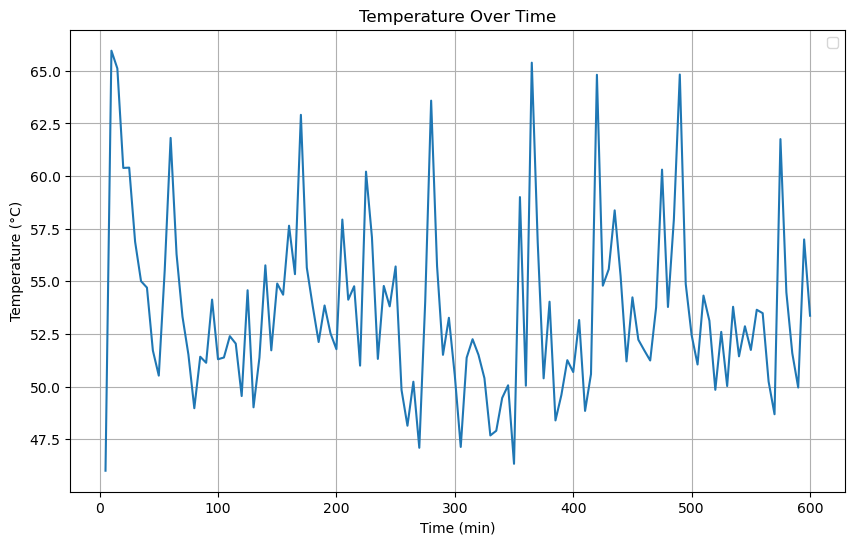

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


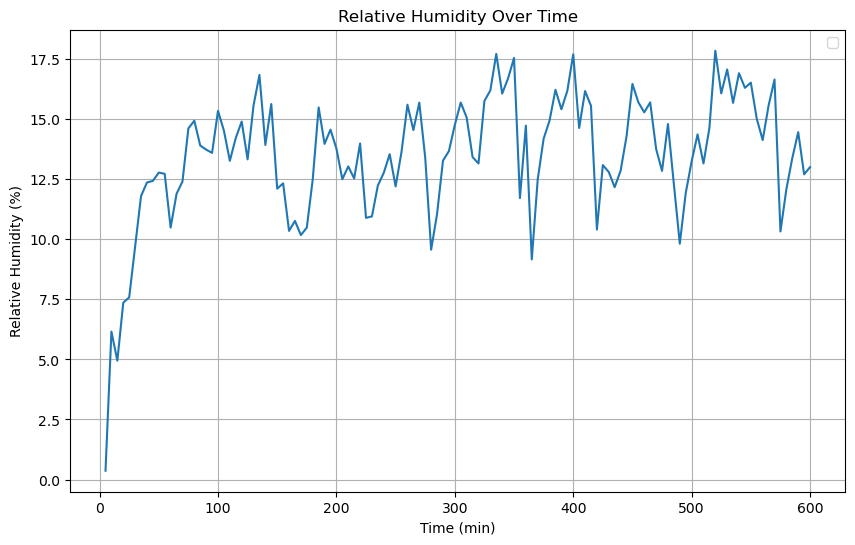

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


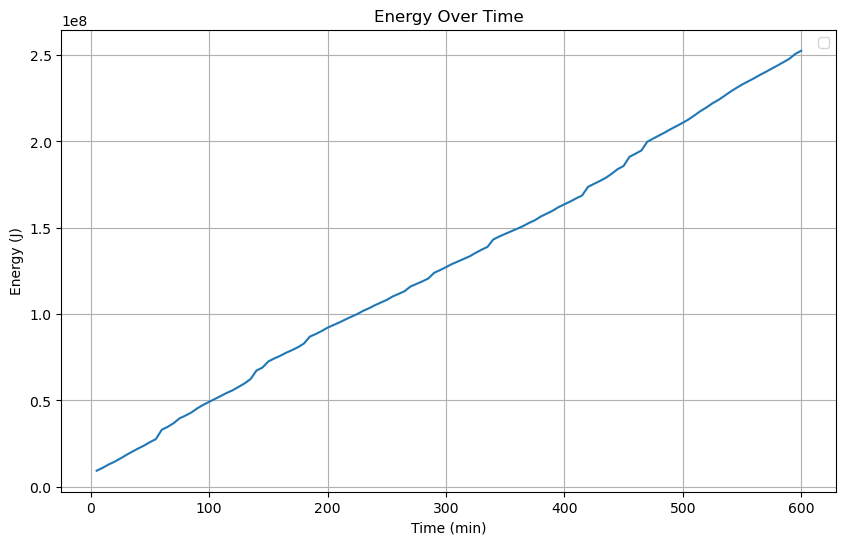

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


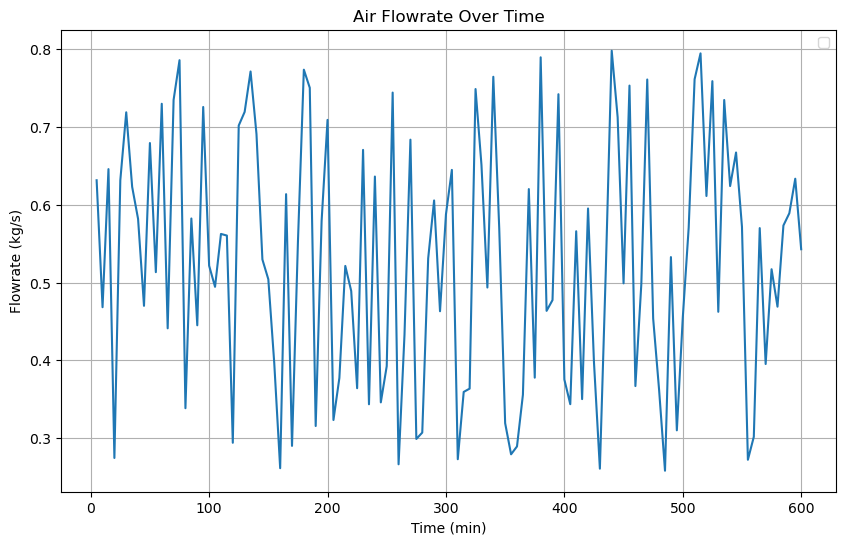

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


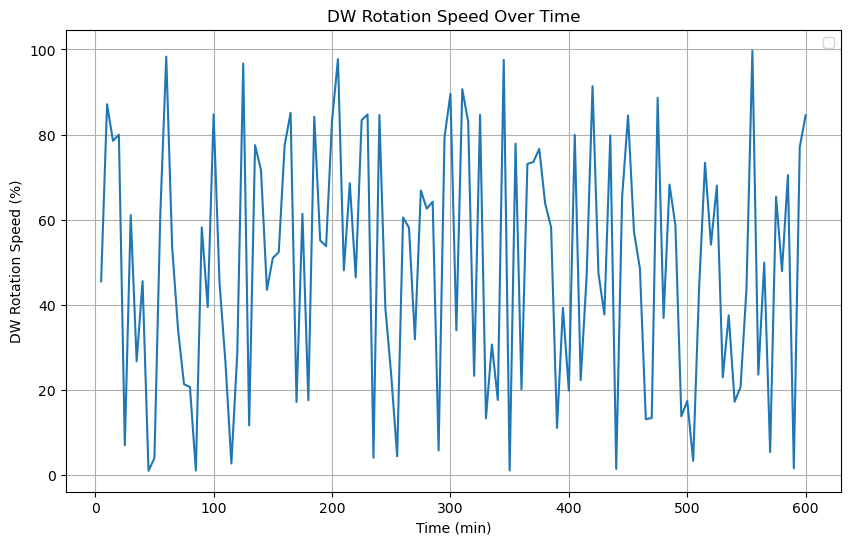

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


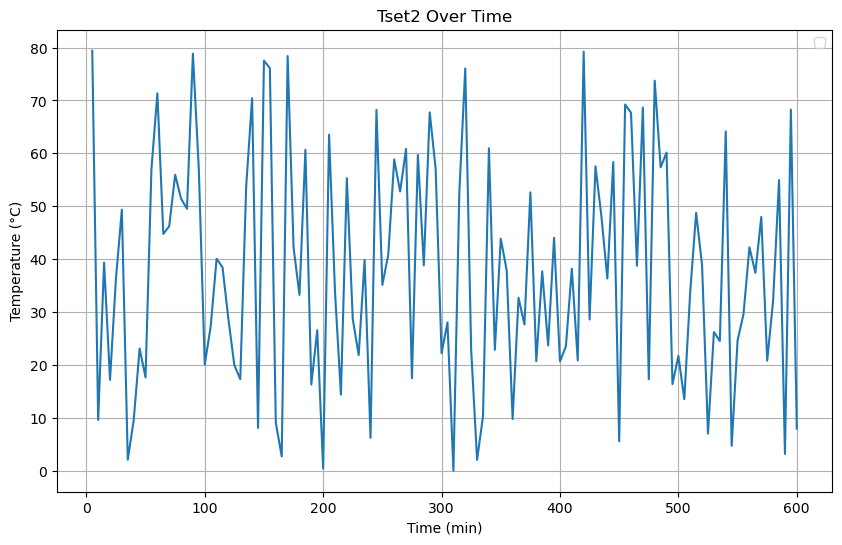

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


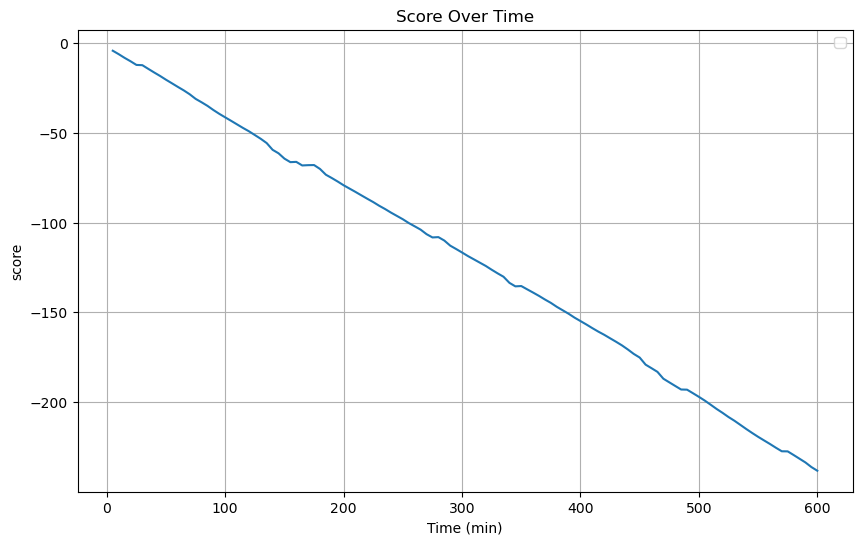

In [4]:
# Plot the results
plt.figure(1,figsize=(10, 6))
#plt.plot(time, moisture_content, label=f'T={T}°C')
plt.plot(time, Temp_fc)
plt.xlabel('Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results
plt.figure(2,figsize=(10, 6))
#plt.plot(time, moisture_content, label=f'T={T}°C')
plt.plot(time, RH_fc)
plt.xlabel('Time (min)')
plt.ylabel('Relative Humidity (%)')
plt.title('Relative Humidity Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results
plt.figure(3,figsize=(10, 6))
#plt.plot(time, moisture_content, label=f'T={T}°C')
plt.plot(time, Energy)
plt.xlabel('Time (min)')
plt.ylabel('Energy (J)')
plt.title('Energy Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Plot the results
plt.figure(4,figsize=(10, 6))
#plt.plot(time, moisture_content, label=f'T={T}°C')
plt.plot(time, Flow_r)
plt.xlabel('Time (min)')
plt.ylabel('Flowrate (kg/s)')
plt.title('Air Flowrate Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results
plt.figure(5,figsize=(10, 6))
#plt.plot(time, moisture_content, label=f'T={T}°C')
plt.plot(time, N)
plt.xlabel('Time (min)')
plt.ylabel('DW Rotation Speed (%)')
plt.title('DW Rotation Speed Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results
plt.figure(6,figsize=(10, 6))
#plt.plot(time, moisture_content, label=f'T={T}°C')
plt.plot(time, Tset2)
plt.xlabel('Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Tset2 Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results
plt.figure(7,figsize=(10, 6))
#plt.plot(time, moisture_content, label=f'T={T}°C')
plt.plot(time, score_all)
plt.xlabel('Time (min)')
plt.ylabel('score')
plt.title('Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
print(RH_fc[0])

0.3676763217734918


In [21]:
for i in range(6,30):
    print(i)

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [45]:
env.action_space

Tuple(Box(0.25, 0.8, (1,), float32), Box(1.0, 100.0, (1,), float32), Box(273.15, 353.15, (1,), float32))

In [46]:
len(env.action_space)

3

In [93]:
env.obs_env

{'agent_0': [307.3040858762864,
  0.4634988379604137,
  353.1430998737052,
  0.05251595758179503,
  353.2236752855649,
  0.05250842959400341,
  316.9923599944319,
  0.39618783362045323,
  295.02863852068975,
  0.9499330962588922,
  307.30420349004197,
  0.4626060647057039,
  329.0571758068676,
  0.11528229039988007,
  329.1087146118379,
  0.11526408381945673,
  240.23219023945424],
 'agent_1': [307.3040858762864,
  0.4634988379604137,
  353.1430998737052,
  0.05251595758179503,
  353.2236752855649,
  0.05250842959400341,
  316.9923599944319,
  0.39618783362045323,
  295.02863852068975,
  0.9499330962588922,
  307.30420349004197,
  0.4626060647057039,
  329.0571758068676,
  0.11528229039988007,
  329.1087146118379,
  0.11526408381945673,
  3.594277215176756],
 'agent_2': [307.3040858762864,
  0.4634988379604137,
  353.1430998737052,
  0.05251595758179503,
  353.2236752855649,
  0.05250842959400341,
  316.9923599944319,
  0.39618783362045323,
  295.02863852068975,
  0.9499330962588922,
 

In [96]:
len(env.obs_env['agent_0'])

17

In [98]:
(6000-7000)/6000.0

-0.16666666666666666

In [66]:
env.state[5]

0.00043075923658490923

In [71]:
env.state[28]

0.13062190805085003

In [73]:
len(env.obs_env['agent_0'])

19

In [82]:
# Define the dictionary
A = {'a': [1, 2, 3], 'b': [4, 5, 6]}

# Add an element to the list associated with the key 'a'
A['a'].append(4)

# Print the updated dictionary
print(A)

{'a': [1, 2, 3, 4], 'b': [4, 5, 6]}


In [84]:
type(env.obs_env['agent_0'])

list

In [90]:
env.obs_env

{'agent_0': [307.3036359713426,
  0.4630771984818725,
  362.40084246367763,
  0.03641513743462494,
  362.5186639241057,
  0.03641130517184492,
  319.121331433602,
  0.3868886400584028,
  294.86288123991716,
  0.9544019733197437,
  307.30417297992227,
  0.46260795166327046,
  327.1425373490629,
  0.12347113008274009,
  327.18179071445167,
  0.12345163016100295,
  150.96383984099782],
 'agent_1': [307.3036359713426,
  0.4630771984818725,
  362.40084246367763,
  0.03641513743462494,
  362.5186639241057,
  0.03641130517184492,
  319.121331433602,
  0.3868886400584028,
  294.86288123991716,
  0.9544019733197437,
  307.30417297992227,
  0.46260795166327046,
  327.1425373490629,
  0.12347113008274009,
  327.18179071445167,
  0.12345163016100295,
  150.96383984099782],
 'agent_2': [307.3036359713426,
  0.4630771984818725,
  362.40084246367763,
  0.03641513743462494,
  362.5186639241057,
  0.03641130517184492,
  319.121331433602,
  0.3868886400584028,
  294.86288123991716,
  0.9544019733197437,

In [97]:
3.0e8/(3600*10)

8333.333333333334

In [11]:
a=[]
b=[1,2,3]
c=[4,5,6]
a.append(b)
a.append(c)

In [12]:
a.append(b)

In [13]:
print(a)

[[1, 2, 3], [4, 5, 6], [1, 2, 3]]


In [14]:
a.append([100,2])

In [15]:
print(a)

[[1, 2, 3], [4, 5, 6], [1, 2, 3], [100, 2]]


In [18]:
a[3]

[100, 2]